<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint7/Module3/O1_GetPermutationImportancesForModelInterpretationAndFeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
# Import libraries, load data, and view import pandas as pd
url = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/main/data/weather/weatherAUS.csv"
weather = pd.read_csv(url)
weather.head()

# Drop columns with high-percentage of missing values (and the leaky feature)
cols_drop = ['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM']
weather_drop = weather.drop(cols_drop, axis=1)

# Convert the 'Date' column to datetime, extract month
weather_drop['Date'] = pd.to_datetime(weather_drop['Date'], infer_datetime_format=True).dt.month

In [3]:
# Imports
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


# Define the numeric features
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                    'WindSpeed9am','WindSpeed3pm', 'Humidity9am',
                    'Humidity3pm', 'Pressure9am','Pressure3pm',
                    'Temp9am', 'Temp3pm']

# Create the transformer (impute, scale)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define the categorical features
categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())])

# Define how the numeric and categorical features will be transformed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the pipeline steps, including the classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', DecisionTreeClassifier())])

In [4]:
# Create the feature matrix
X = weather_drop.drop('RainTomorrow', axis=1)

# Create and encode the target array
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
y=label_enc.fit_transform(weather_drop['RainTomorrow'])

# Import the train_test_split utility
from sklearn.model_selection import train_test_split

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train,y_train)
print('Validation Accuracy', clf.score(X_test, y_test))

Validation Accuracy 0.7672983490294504


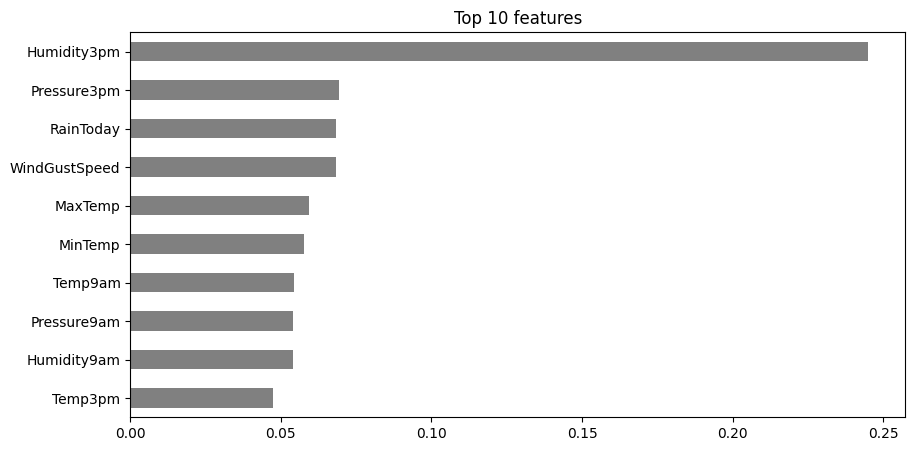

In [5]:
# Features (order in which they were preprocessed)
features_order = numeric_features + categorical_features

importances = pd.Series(clf.steps[1][1].feature_importances_, features_order)

# Plot feature importances
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

plt.show()

Now we can start the permutation of one feature and try different features:

In [6]:
# Permute the values in the more important column
feature = 'Humidity3pm'
X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  Humidity3pm
Validation Accuracy 0.7672983490294504
Validation Accuracy (permuted) 0.6689308987082364


The accuracy went down, as we would expect if this feature was important to the model. So Humidity3pm has some effect on the model. Let's try another feature.

In [7]:
# Permute the values in a less important column
feature = 'WindSpeed3pm'
X_test_permuted = X_test.copy()

# Fill in missing values
X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', clf.score(X_test, y_test))
print('Validation Accuracy (permuted)', clf.score(X_test_permuted, y_test))

Feature permuted:  WindSpeed3pm
Validation Accuracy 0.7672983490294504
Validation Accuracy (permuted) 0.7556932003960487


The decrease in accuracy was not nearly as significant, so WindSpeed3pm is not as important to the model.